# \<Title\>

## NEVER 'RUN ALL' (!) 

Imports

In [40]:
import os
import sys
import logging
import datetime
import dill as pickle
import matplotlib.pyplot as plt

Import custom libraries

In [41]:
# original py files
sys.path.insert(1, 'methods')

from data_methods import getData, standardize
from dimensionality_reduction import reduce_dimensionality,reduce_with
from beamSearch import EMM, as_string
from adjPysubgroup import adjustedBestFirstSearch, adjustedDFS, adjustedApriori
from qualityMeasures import calc_result_bs, calc_result_ps
from interpretabilityMeasures import Feature_Correlation_Scores, DBI_beam, DBI_ps

## 1. Functions

In [42]:
def export_results(save_path,file_name,data):
    """Function to export the data to a temporary or final file.
    save_path: directory/folder to which the data should be saved.
    file_name: name of the file
    data: data that should be saved
    """
    file_path = os.path.join(save_path,file_name)
    with open(file_path,'wb') as f:
        pickle.dump(data,f)
    
    logging.info(f"{'Temporary results' if 'temp' in file_name else 'Results'} saved to {file_path}")


def run_search_method(search_method, method_name, df, save_path, reduction_method):
    """
    Method that runs a search method for the original and the encoded data, and returns the results in a dictionary 
    search_method: search method which is a function
    method_name: name of the search method to create temporary file_name
    df: input dataframe
    save_path: path to which temporary data should be saved
    """
    # original data
    start_time = datetime.datetime.now()
    results = search_method(df)
    if 'BS' not in method_name:
        results['subgroup'] = results['subgroup'].apply(lambda x: str(x))
    running_time = datetime.datetime.now() - start_time

    data = {
        'results_org': results,
        'running_time_org': running_time,
    }

    export_results(save_path,f'temp-results-{method_name}-{reduction_method}.pkl',data)

    return data


def get_results_dataset(dataset_name : str, optimal_features: dict, num_epochs = 100, save_path = 'sd_results',dct_data=None):

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # ---------=| open data |=---------
    logging.info(f'Opening the {dataset_name} dataset...')
    df, cat, num, features = getData(dataset_name)

    # ---------=| reduce dimensionality |=---------
    if dct_data is None:
        logging.info('Reducing dimensionality...')
        dct_data={
            'vanilla': df.copy(),
        }

        for reduction_method in ['auto_encoder', 'PCA', 'SPCA']:
            df_encoded,_ = reduce_dimensionality(
                    data=df,
                    reduction_method=reduction_method,
                    catColumns=cat,
                    numColumns=num, 
                    nFeatures=optimal_features[reduction_method],
                    nEpochs=num_epochs
                )
            
            dct_data[reduction_method]=df_encoded.copy()
            # temporary export as safety feature
            export_results(save_path,f'{dataset_name}-temp-results-reductions-{reduction_method}.pkl',dct_data)
        
        # export all data
        export_results(save_path,f'{dataset_name}-data-reductions.pkl',dct_data)
    else:
        logging.info('Data was already reduced')


    # ---------=| find subgroups |=---------
    logging.info('Finding subgroups...')

    beamSearch = lambda df_: EMM(100, 3, 100, [], df_, 'target', ensure_diversity=True, prnt=True)
    dct_results = {}

    # iterate over all types of dimensionality reduction and all search methods
    for reduction_method in ['vanilla', 'auto_encoder', 'PCA', 'SPCA']:
        logging.info(reduction_method)
        
        logging.info(' -> starting BFS')
        # - Best-First Search
        dct_bfs = run_search_method(adjustedBestFirstSearch,f'BFS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        logging.info(' -> starting DFS')
        # - Depth-First Search
        dct_dfs = run_search_method(adjustedDFS,f'DFS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        logging.info(' -> starting Apriori')
        # - Apriori
        dct_apri = run_search_method(adjustedApriori,f'APRI-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        logging.info(' -> starting Beam Search')
        # - Beam Search      
        dct_bs = run_search_method(beamSearch,f'BS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        # save results to overall dictionary
        dct_results[reduction_method] = {
            'Best-First Search':dct_bfs,
            'Depth-First Search':dct_dfs,
            'Apriori':dct_apri,
            'Beam Search':dct_bs
        }

        # save intermediate results
        now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
        export_results(save_path,f'{dataset_name}-temp-results-{reduction_method}-{now}.pkl',dct_results)
    
    # ---------=| export all results |=---------
    logging.info("Exporting Results...")

    now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
    export_results(save_path,f'{dataset_name}-results-{now}.pkl',dct_results)
    
    return dct_results

## 2. Find Optimal Numbers of Features

In [43]:
def plot_mse_vs_nfeatures(dct_datasets,name_dataset,reduction_method,l_est,r_est):

    df = dct_datasets[name_dataset]['df']
    cat = dct_datasets[name_dataset]['cat']
    num = dct_datasets[name_dataset]['num']

    start_time = datetime.datetime.now()
    mseList = []

    for i in range(l_est, r_est+1):

        _,mse = reduce_dimensionality(
                    data=df,
                    reduction_method=reduction_method,
                    catColumns=cat,
                    numColumns=num, 
                    nFeatures=i,
                    nEpochs=100
                )

        mseList.append(mse)

    running_time = datetime.datetime.now()-start_time

    plt.plot([i for i in range(l_est, r_est+1)], mseList)
    plt.xlabel("Nr of Features") # ! new
    plt.ylabel("MSE") # ! new
    plt.show()

    logging.info(running_time)

In [44]:
# get all datasets
lst_dataset_names = ["Ionosphere","Mushroom","Adult","Soybean","Arrhythmia", "Indoor"] #,"Indoor" not in data folder
dct_datasets = {name:{key:val for val,key in zip(getData(name),['df','cat','num','features'])} for name in lst_dataset_names}

# define min and max estimates of nr of features
l_est,r_est=2,12
dct_optimal_features = {}

### 2.1 Ionosphere

In [8]:
dct_ion = {}

#### 2.1.1 Auto-Encoder

11/11 [==============================] - 0s 1ms/step


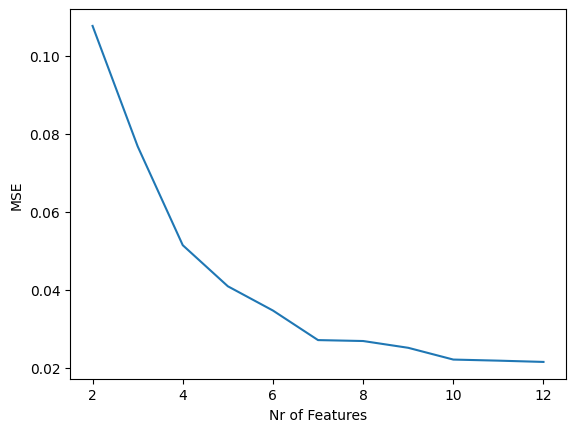

In [8]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','auto_encoder',l_est,r_est)

In [9]:
dct_ion['auto_encoder'] = 5

#### 2.1.2 PCA

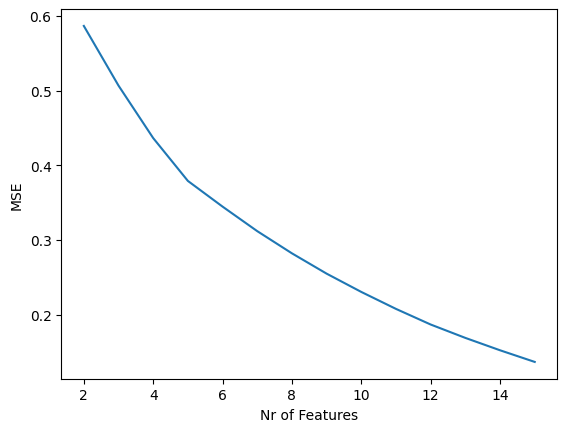

In [10]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','PCA',l_est,r_est=15)

In [10]:
dct_ion['PCA'] = 5 

#### 2.1.3 Sparse-PCA

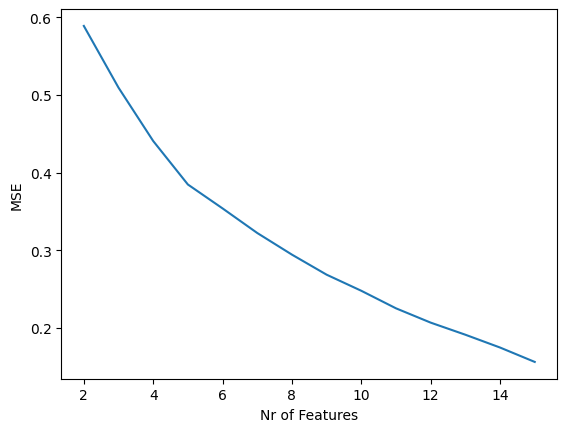

In [12]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','SPCA',l_est,r_est=15)

In [11]:
dct_ion['SPCA'] = 5 

### 2.2 Mushroom

In [46]:
dct_shroom = {}

#### 2.2.1 Auto-Encoder

254/254 [==============================] - 0s 2ms/step


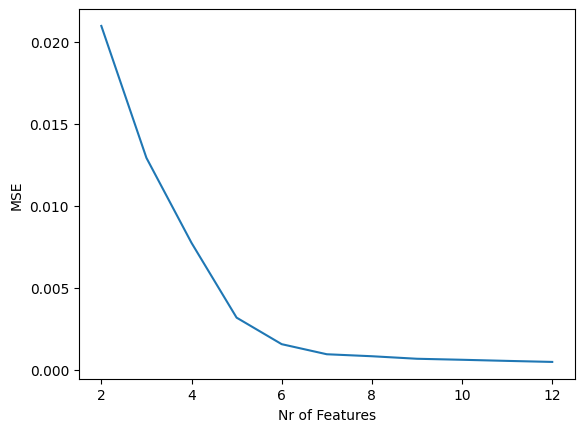

In [15]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','auto_encoder',l_est,r_est)

In [47]:
dct_shroom['auto_encoder'] = 5

#### 2.2.2 PCA

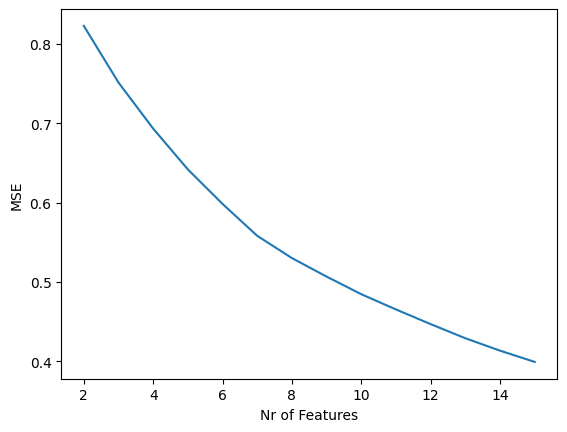

In [17]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','PCA',l_est,r_est=15)

In [48]:
dct_shroom['PCA'] = 7

#### 2.2.3 SPCA

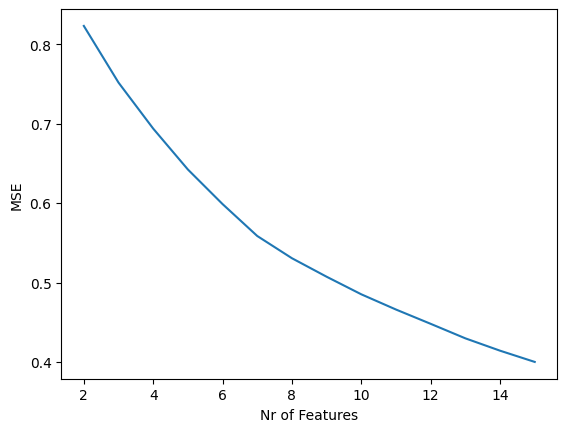

In [19]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','SPCA',l_est,r_est=15)

In [15]:
dct_shroom['SPCA'] = 7

### 2.3 Adult

In [16]:
dct_adult = {}

#### 2.3.1 Auto-Encoder

1527/1527 [==============================] - 2s 2ms/step


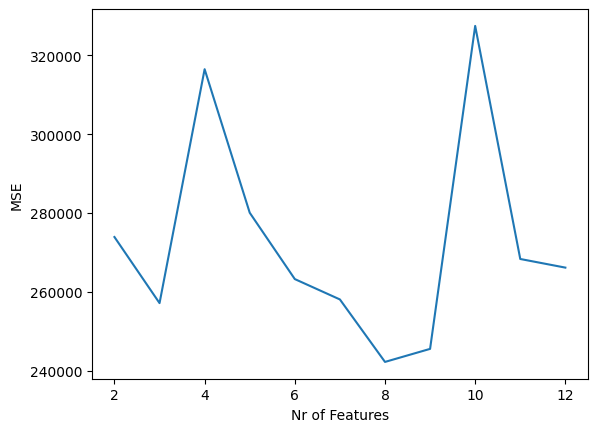

In [22]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','auto_encoder',l_est,r_est)

In [17]:
dct_adult['auto_encoder'] = 3

#### 2.3.2 PCA

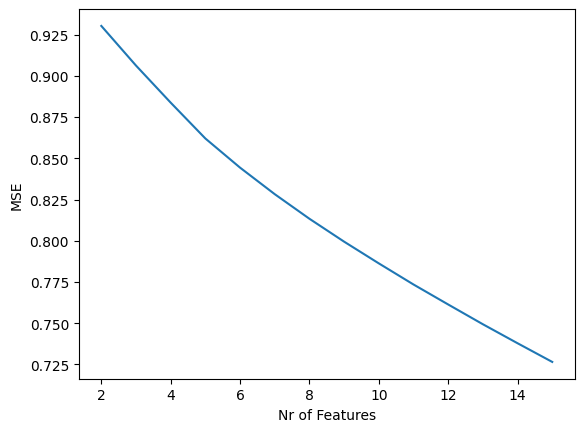

In [24]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','PCA',l_est,r_est=15)

In [18]:
dct_adult['PCA'] = 5 #Not entirely sure here. Theres a small elbow at 5, but its pretty constant

#### 2.3.3 SPCA

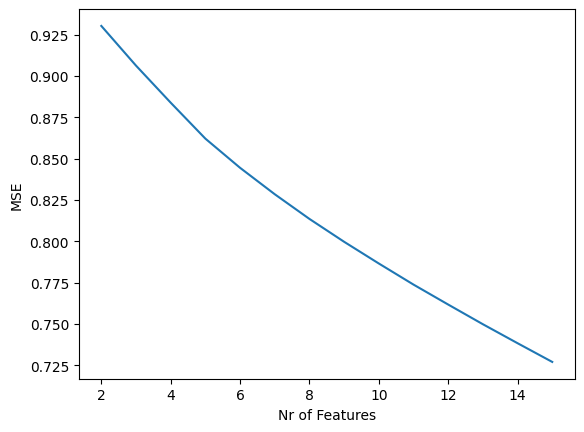

In [26]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','SPCA',l_est,r_est=15)

In [19]:
dct_adult['SPCA'] = 5 #Same comment as above

### 2.4 Soybean

In [20]:
dct_soy = {}

#### 2.4.1 Auto-Encoder

9/9 [==============================] - 0s 873us/step


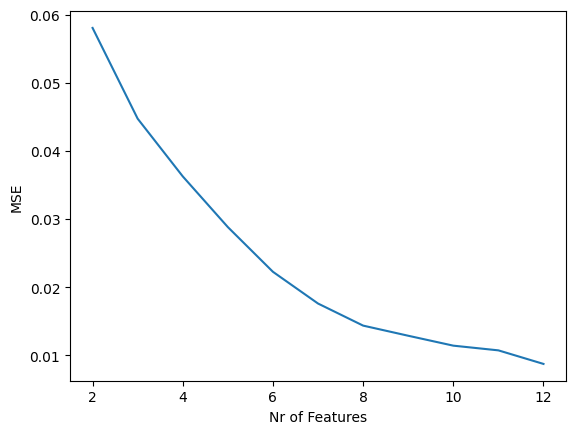

In [29]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','auto_encoder',l_est,r_est)

In [21]:
dct_soy['auto_encoder'] = 6 # This seems to be the second elbow but feels right haha

#### 2.4.2 PCA

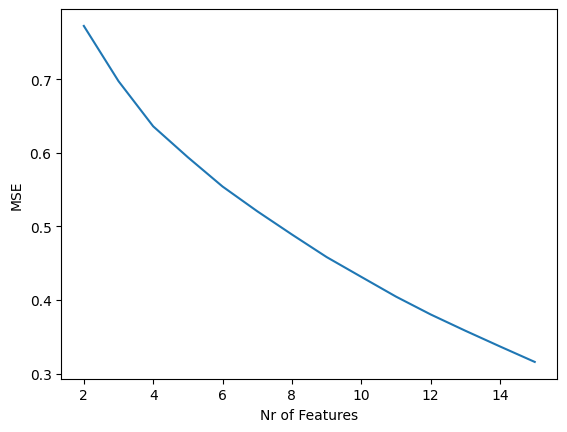

In [31]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','PCA',l_est,r_est=15)

In [22]:
dct_soy['PCA'] = 4

#### 2.4.3 SPCA

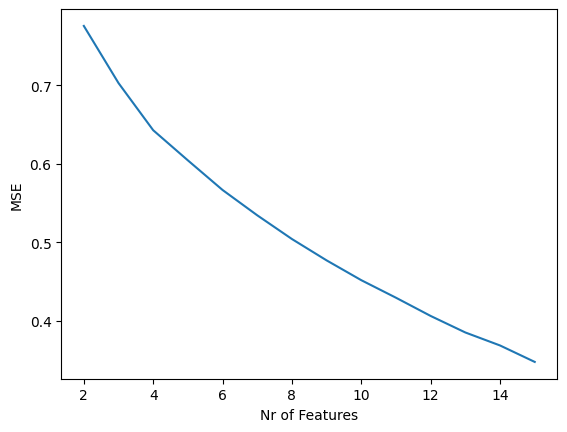

In [33]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','SPCA',l_est,r_est=15)

In [23]:
dct_soy['SPCA'] = 4

### 2.5 Arrhythmia

In [24]:
dct_arrh = {}

#### 2.5.1 Auto-Encoder

14/14 [==============================] - 0s 2ms/step


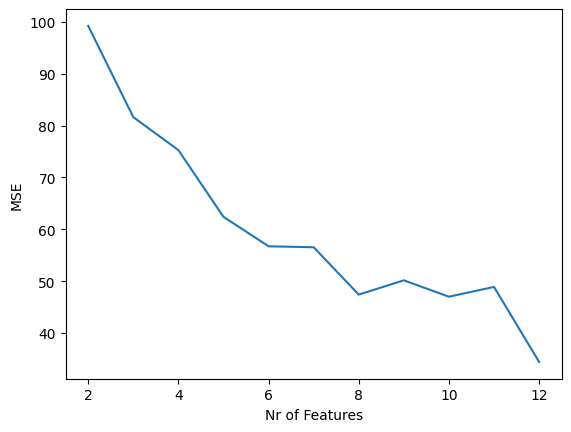

In [36]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','auto_encoder',l_est,r_est)

In [25]:
dct_arrh['auto_encoder'] = 5 # or 6? (lory: i left it as 5, seemed ok)

#### 2.5.2 PCA

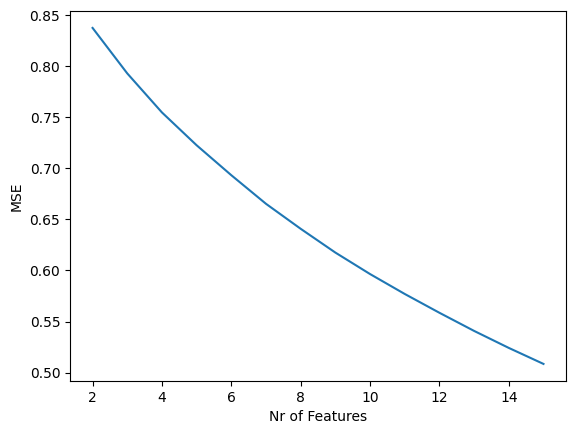

In [38]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','PCA',l_est,r_est=15)

In [26]:
dct_arrh['PCA'] = 4 # or 5? (lory: i left it as 4)

#### 2.5.3 SPCA

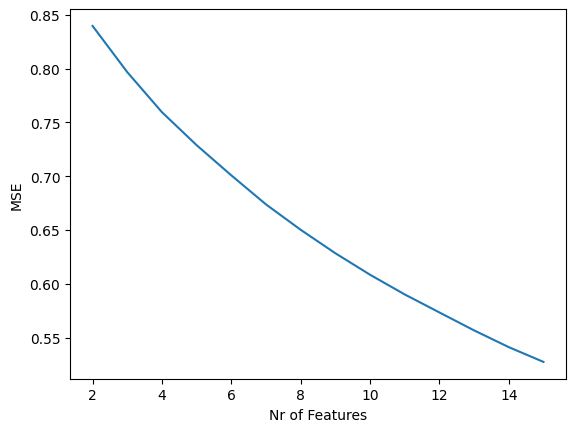

In [40]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','SPCA',l_est,r_est=15)

In [27]:
dct_arrh['SPCA'] = 4

### 2.6 Indoor

In [28]:
dct_indoor = {}

#### 2.6.1 Auto-Encoder

658/658 [==============================] - 1s 1ms/step


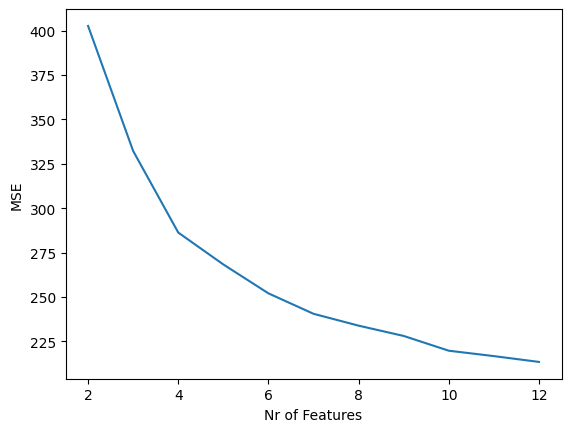

In [43]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','auto_encoder',l_est,r_est)

In [29]:
dct_indoor['auto_encoder'] = 4

#### 2.6.2 PCA

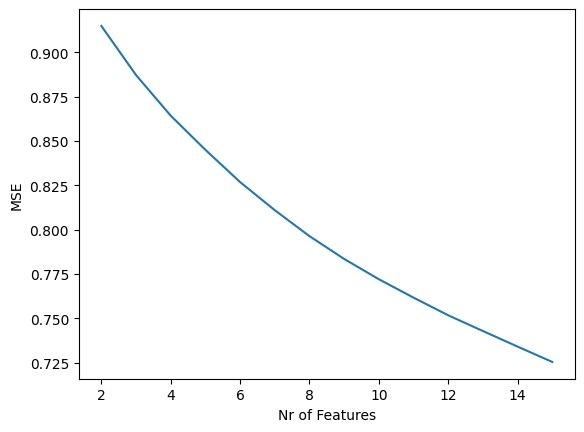

In [45]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','PCA',l_est,r_est=15)

In [30]:
dct_indoor['PCA'] = 4

#### 2.6.3 SPCA

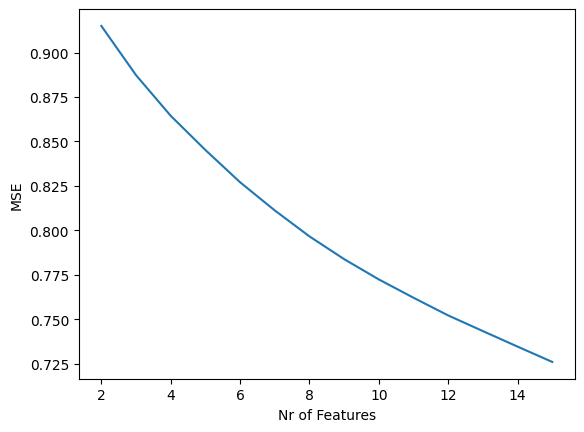

In [47]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','SPCA',l_est,r_est=15)

In [31]:
dct_indoor['SPCA'] = 4

### 2.7 General Dictionary

In [15]:
dct_opt_feat = {
    'Ionosphere':dct_ion,
    'Mushroom':dct_shroom,
    'Adult':dct_adult,
    'Soybean':dct_soy,
    'Arrhythmia':dct_arrh,
    # 'Indoor':dct_indoor
}

## 3. Get Results

In [33]:
# get all combinations of smaller datasets & reduction method
dct_opt_feat = {
    'Soybean':dct_soy,
    'Ionosphere':dct_ion,
    'Arrhythmia':dct_arrh,
}

for dataset_name, optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features)

9/9 [==============================] - 0s 1ms/step


c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['attribute1 != 6']
eta  ['attribute1 != 6']
    seed :  ['attribute1 != 4']
eta  ['attribute1 != 4']
    seed :  ['attribute1 != 3']
eta  ['attribute1 != 3']
    seed :  ['attribute1 != 5']
eta  ['attribute1 != 5']
    seed :  ['attribute1 != 1']
eta  ['attribute1 != 1']
    seed :  ['attribute1 != 0']
eta  ['attribute1 != 0']
    seed :  ['attribute1 != 2']
eta  ['attribute1 != 2']
    seed :  ['attribute2 != 0']
eta  ['attribute2 != 0']
    seed :  ['attribute2 != 1']
eta  ['attribute2 != 1']
    seed :  ['attribute3 != 2']
eta  ['attribute3 != 2']
    seed :  ['attribute3 != 0']
eta  ['attribute3 != 0']
    seed :  ['attribute3 != 1']
eta  ['attribute3 != 1']
    seed :  ['attribute4 != 1']
eta  ['attribute4 != 1']
    seed :  ['attribute4 != 2']
eta  ['attribute4 != 2']
    seed :  ['attribute4 != 0']
eta  ['attribute4 != 0']
    seed :  ['attribute5 != 0']
eta  ['attribute5 != 0']
    seed :  ['attribute5 != 1']
eta  ['attr

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


    seed :  ['cat3 <= 0.04569911708434447']
eta  ['cat3 <= 0.04569911708434447']
    seed :  ['cat3 <= -0.4057297334074974']
eta  ['cat3 <= -0.4057297334074974']
    seed :  ['cat3 <= -0.778684139251709']
eta  ['cat3 <= -0.778684139251709']
    seed :  ['cat1 <= -0.15148374438285828']
eta  ['cat1 <= -0.15148374438285828']
    seed :  ['cat1 <= 0.5082417726516724']
eta  ['cat1 <= 0.5082417726516724']
    seed :  ['cat1 <= -0.37119291722774506']
eta  ['cat1 <= -0.37119291722774506']
    seed :  ['cat1 <= -0.5495014786720276']
eta  ['cat1 <= -0.5495014786720276']
    seed :  ['cat6 <= -0.11934126913547516']
eta  ['cat6 <= -0.11934126913547516']
    seed :  ['cat5 <= -0.328486792743206']
eta  ['cat5 <= -0.328486792743206']
    seed :  ['cat5 <= -0.5752449035644531']
eta  ['cat5 <= -0.5752449035644531']
    seed :  ['cat2 <= -0.0883678700774908']
eta  ['cat2 <= -0.0883678700774908']
    seed :  ['cat6 <= -0.45863434672355646']
eta  ['cat6 <= -0.45863434672355646']
    seed :  ['cat2 <= 0.43

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC1 <= -3.6349923186069324']
eta  ['PC1 <= -3.6349923186069324']
    seed :  ['PC2 <= -1.5988893278804086']
eta  ['PC2 <= -1.5988893278804086']
    seed :  ['PC1 <= -1.043457628808658']
eta  ['PC1 <= -1.043457628808658']
    seed :  ['PC3 > -0.8519585137372641']
eta  ['PC3 > -0.8519585137372641']
    seed :  ['PC1 <= 0.46339990797198805']
eta  ['PC1 <= 0.46339990797198805']
    seed :  ['PC2 <= -0.6397846563173876']
eta  ['PC2 <= -0.6397846563173876']
    seed :  ['PC1 <= -4.260804368309496']
eta  ['PC1 <= -4.260804368309496']
    seed :  ['PC2 <= -2.007346885426295']
eta  ['PC2 <= -2.007346885426295']
    seed :  ['PC3 > -1.390301391503424']
eta  ['PC3 > -1.390301391503424']
    seed :  ['PC3 > -1.2220225879859743']
eta  ['PC3 > -1.2220225879859743']
    seed :  ['PC3 > -1.5685306866807833']
eta  ['PC3 > -1.5685306866807833']
    seed :  ['PC2 <= -0.2842258105503006']
eta  ['PC2 <= -0.2842258105503006']
    seed :  ['PC4 <= -1

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC1 > -1.8724046217917176']
eta  ['PC1 > -1.8724046217917176']
    seed :  ['PC1 > -2.387805361978601']
eta  ['PC1 > -2.387805361978601']
    seed :  ['PC3 <= 0.9524243205193276']
eta  ['PC3 <= 0.9524243205193276']
    seed :  ['PC1 > -2.56145872218066']
eta  ['PC1 > -2.56145872218066']
    seed :  ['PC3 <= 0.33482394325542764']
eta  ['PC3 <= 0.33482394325542764']
    seed :  ['PC1 > -2.6313758914636365']
eta  ['PC1 > -2.6313758914636365']
    seed :  ['PC3 <= 1.1414640452354985']
eta  ['PC3 <= 1.1414640452354985']
    seed :  ['PC2 > -1.0558344945603002']
eta  ['PC2 > -1.0558344945603002']
    seed :  ['PC3 <= -0.2569349281097326']
eta  ['PC3 <= -0.2569349281097326']
    seed :  ['PC4 > -0.16351175335909196']
eta  ['PC4 > -0.16351175335909196']
    seed :  ['PC2 <= -2.4279700471202457']
eta  ['PC2 <= -2.4279700471202457']
    seed :  ['PC2 <= -2.1911547986655644']
eta  ['PC2 <= -2.1911547986655644']
    seed :  ['PC4 > -0.7020

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['attribute21 > 0.0']
eta  ['attribute21 > 0.0']
    seed :  ['attribute22 > -0.14815']
eta  ['attribute22 > -0.14815']
    seed :  ['attribute25 > -0.47137']
eta  ['attribute25 > -0.47137']
    seed :  ['attribute29 > -0.38059']
eta  ['attribute29 > -0.38059']
    seed :  ['attribute11 > -0.002969999999999957']
eta  ['attribute11 > -0.002969999999999957']
    seed :  ['attribute23 > 0.0']
eta  ['attribute23 > 0.0']
    seed :  ['attribute23 > -0.366885']
eta  ['attribute23 > -0.366885']
    seed :  ['attribute25 > -0.33239']
eta  ['attribute25 > -0.33239']
    seed :  ['attribute16 <= -0.09483']
eta  ['attribute16 <= -0.09483']
    seed :  ['attribute33 <= -0.16535']
eta  ['attribute33 <= -0.16535']
    seed :  ['attribute15 > -0.081705']
eta  ['attribute15 > -0.081705']
    seed :  ['attribute5 > -0.06151']
eta  ['attribute5 > -0.06151']
    seed :  ['attribute15 > -0.15616']
eta  ['attribute15 > -0.15616']
    seed :  ['attrib

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['cat2 <= -0.27220052480697615']
eta  ['cat2 <= -0.27220052480697615']
    seed :  ['cat2 <= 0.2251737415790558']
eta  ['cat2 <= 0.2251737415790558']
    seed :  ['cat2 <= -0.7197302281856537']
eta  ['cat2 <= -0.7197302281856537']
    seed :  ['cat2 <= -1.0460646152496338']
eta  ['cat2 <= -1.0460646152496338']
    seed :  ['cat5 <= 0.25740414857864474']
eta  ['cat5 <= 0.25740414857864474']
    seed :  ['cat4 <= -0.5211089253425598']
eta  ['cat4 <= -0.5211089253425598']
    seed :  ['cat4 <= -0.3876272737979889']
eta  ['cat4 <= -0.3876272737979889']
    seed :  ['cat1 > -0.6328057050704956']
eta  ['cat1 > -0.6328057050704956']
    seed :  ['cat1 > -1.0099435647328694']
eta  ['cat1 > -1.0099435647328694']
    seed :  ['cat4 <= -0.23530286053816465']
eta  ['cat4 <= -0.23530286053816465']
    seed :  ['cat5 <= -0.2885477691888809']
eta  ['cat5 <= -0.2885477691888809']
    seed :  ['cat3 > -0.35306549072265625']
eta  ['cat3 > -0.35306

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC3 <= -0.375345683595483']
eta  ['PC3 <= -0.375345683595483']
    seed :  ['PC3 <= -0.8411241327609837']
eta  ['PC3 <= -0.8411241327609837']
    seed :  ['PC3 <= 0.15641743988115742']
eta  ['PC3 <= 0.15641743988115742']
    seed :  ['PC3 <= -1.2985394453332106']
eta  ['PC3 <= -1.2985394453332106']
    seed :  ['PC1 <= 0.5682340475231731']
eta  ['PC1 <= 0.5682340475231731']
    seed :  ['PC5 <= -0.5799295137498097']
eta  ['PC5 <= -0.5799295137498097']
    seed :  ['PC5 <= -0.43683594851432694']
eta  ['PC5 <= -0.43683594851432694']
    seed :  ['PC5 <= -0.31209017673914596']
eta  ['PC5 <= -0.31209017673914596']
    seed :  ['PC1 <= -1.9239266521725098']
eta  ['PC1 <= -1.9239266521725098']
    seed :  ['PC2 <= -0.20743226144822244']
eta  ['PC2 <= -0.20743226144822244']
    seed :  ['PC2 <= -0.6894251155691266']
eta  ['PC2 <= -0.6894251155691266']
    seed :  ['PC1 > -3.0748128860168156']
eta  ['PC1 > -3.0748128860168156']
    see

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  1
    seed :  ['PC1 <= 0.2014646541101225']
eta  ['PC1 <= 0.2014646541101225']
    seed :  ['PC1 <= -2.7640640047875595']
eta  ['PC1 <= -2.7640640047875595']
    seed :  ['PC3 <= -1.0387776641109294']
eta  ['PC3 <= -1.0387776641109294']
    seed :  ['PC3 <= -0.839053811260168']
eta  ['PC3 <= -0.839053811260168']
    seed :  ['PC3 <= -1.2529130894446971']
eta  ['PC3 <= -1.2529130894446971']
    seed :  ['PC1 <= -2.5249082590455894']
eta  ['PC1 <= -2.5249082590455894']
    seed :  ['PC1 <= -2.159589611368764']
eta  ['PC1 <= -2.159589611368764']
    seed :  ['PC5 <= -0.6473349247943382']
eta  ['PC5 <= -0.6473349247943382']
    seed :  ['PC3 <= -0.6228865988201017']
eta  ['PC3 <= -0.6228865988201017']
    seed :  ['PC5 <= -0.46397396397842555']
eta  ['PC5 <= -0.46397396397842555']
    seed :  ['PC5 <= -0.30081572303055715']
eta  ['PC5 <= -0.30081572303055715']
    seed :  ['PC2 > -1.274262508661695']
eta  ['PC2 > -1.274262508661695']
    seed :  ['PC2 > 0.07058411853389873']
eta  

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['attribute242 <= -14.02']
eta  ['attribute242 <= -14.02']
    seed :  ['attribute137 > 40.0']
eta  ['attribute137 > 40.0']
    seed :  ['attribute225 <= -0.6']
eta  ['attribute225 <= -0.6']
    seed :  ['attribute249 <= -0.6']
eta  ['attribute249 <= -0.6']
    seed :  ['attribute198 > -34.12']
eta  ['attribute198 > -34.12']
    seed :  ['attribute218 <= 4.3']
eta  ['attribute218 <= 4.3']
    seed :  ['attribute236 <= 1.3']
eta  ['attribute236 <= 1.3']
    seed :  ['attribute159 <= -0.5']
eta  ['attribute159 <= -0.5']
    seed :  ['attribute212 <= -1.4']
eta  ['attribute212 <= -1.4']
    seed :  ['attribute208 <= -1.125']
eta  ['attribute208 <= -1.125']
    seed :  ['attribute246 <= 2.7']
eta  ['attribute246 <= 2.7']
    seed :  ['attribute89 <= 48.0']
eta  ['attribute89 <= 48.0']
    seed :  ['attribute278 <= 28.1']
eta  ['attribute278 <= 28.1']
    seed :  ['attribute177 <= 6.0']
eta  ['attribute177 <= 6.0']
    seed :  ['attri

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['cat5 > 304.70610961914065']
eta  ['cat5 > 304.70610961914065']
    seed :  ['cat5 > 316.85301208496094']
eta  ['cat5 > 316.85301208496094']
    seed :  ['cat5 > 335.77393595377606']
eta  ['cat5 > 335.77393595377606']
    seed :  ['cat5 > 358.74281311035156']
eta  ['cat5 > 358.74281311035156']
    seed :  ['cat4 <= 1.8860704898834229']
eta  ['cat4 <= 1.8860704898834229']
    seed :  ['cat2 > -21.371080017089835']
eta  ['cat2 > -21.371080017089835']
    seed :  ['cat1 <= 115.8708724975586']
eta  ['cat1 <= 115.8708724975586']
    seed :  ['cat2 > -12.135665655136108']
eta  ['cat2 > -12.135665655136108']
    seed :  ['cat2 > -5.813205877939857']
eta  ['cat2 > -5.813205877939857']
    seed :  ['cat1 <= 74.93379211425781']
eta  ['cat1 <= 74.93379211425781']
    seed :  ['cat1 <= 59.74192523956299']
eta  ['cat1 <= 59.74192523956299']
    seed :  ['cat3 > 140.01590270996095']
eta  ['cat3 > 140.01590270996095']
    seed :  ['cat4 > -41.

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC3 > 0.6741271335837924']
eta  ['PC3 > 0.6741271335837924']
    seed :  ['PC3 > -0.48141472592257606']
eta  ['PC3 > -0.48141472592257606']
    seed :  ['PC4 <= -0.6618844769955637']
eta  ['PC4 <= -0.6618844769955637']
    seed :  ['PC3 > -1.6681332555973052']
eta  ['PC3 > -1.6681332555973052']
    seed :  ['PC3 > -1.1763170076846783']
eta  ['PC3 > -1.1763170076846783']
    seed :  ['PC4 <= -1.6778061765350534']
eta  ['PC4 <= -1.6778061765350534']
    seed :  ['PC2 > -2.00321494074105']
eta  ['PC2 > -2.00321494074105']
    seed :  ['PC2 > -1.312575816696525']
eta  ['PC2 > -1.312575816696525']
    seed :  ['PC2 > -2.5046398190455434']
eta  ['PC2 > -2.5046398190455434']
    seed :  ['PC1 > -3.391573630079247']
eta  ['PC1 > -3.391573630079247']
    seed :  ['PC1 > -2.557596220004997']
eta  ['PC1 > -2.557596220004997']
    seed :  ['PC1 > -1.3322357379714187']
eta  ['PC1 > -1.3322357379714187']
    seed :  ['PC1 > 0.307509260605380

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC4 > -0.48670552292973407']
eta  ['PC4 > -0.48670552292973407']
    seed :  ['PC4 > -1.1738346212601918']
eta  ['PC4 > -1.1738346212601918']
    seed :  ['PC4 > -1.7609923745507239']
eta  ['PC4 > -1.7609923745507239']
    seed :  ['PC4 > 0.6892123325127284']
eta  ['PC4 > 0.6892123325127284']
    seed :  ['PC3 > 0.6196427105872184']
eta  ['PC3 > 0.6196427105872184']
    seed :  ['PC2 <= -0.6940246185012214']
eta  ['PC2 <= -0.6940246185012214']
    seed :  ['PC3 > -1.0048485187330722']
eta  ['PC3 > -1.0048485187330722']
    seed :  ['PC3 > -1.4556067756222844']
eta  ['PC3 > -1.4556067756222844']
    seed :  ['PC2 <= -1.5796035651135103']
eta  ['PC2 <= -1.5796035651135103']
    seed :  ['PC3 > -0.44262895696250093']
eta  ['PC3 > -0.44262895696250093']
    seed :  ['PC1 > -3.6847363166235096']
eta  ['PC1 > -3.6847363166235096']
    seed :  ['PC2 <= -1.9472552683763797']
eta  ['PC2 <= -1.9472552683763797']
    seed :  ['PC1 > -2.84

In [45]:
# get all combinations of bigger datasets & reduction method
dct_opt_feat = {
    'Mushroom':dct_shroom,
}

# get all combinations of dataset & reduction method
for dataset_name, optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features)

254/254 [==============================] - 0s 853us/step
level :  0
    seed :  []
eta  []


c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


UndefinedVariableError: name 'x' is not defined

In [49]:
# get all combinations of bigger datasets & reduction method
dct_opt_feat = {
    'Indoor':dct_indoor
}

# get all combinations of dataset & reduction method
for dataset_name, optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features)

658/658 [==============================] - 1s 757us/step


c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['WAP511 <= 100.0']
eta  ['WAP511 <= 100.0']
    seed :  ['WAP512 <= 100.0']
eta  ['WAP512 <= 100.0']
    seed :  ['WAP513 <= 100.0']
eta  ['WAP513 <= 100.0']
    seed :  ['WAP514 <= 100.0']
eta  ['WAP514 <= 100.0']
    seed :  ['WAP515 <= 100.0']
eta  ['WAP515 <= 100.0']
    seed :  ['WAP516 <= 100.0']
eta  ['WAP516 <= 100.0']
    seed :  ['WAP517 <= 100.0']
eta  ['WAP517 <= 100.0']
    seed :  ['WAP518 <= 100.0']
eta  ['WAP518 <= 100.0']
    seed :  ['WAP519 <= 100.0']
eta  ['WAP519 <= 100.0']
    seed :  ['WAP520 <= 100.0']
eta  ['WAP520 <= 100.0']
    seed :  ['USERID != 2']
eta  ['USERID != 2']
    seed :  ['USERID != 11']
eta  ['USERID != 11']
    seed :  ['USERID != 3']
eta  ['USERID != 3']
    seed :  ['USERID != 4']
eta  ['USERID != 4']
    seed :  ['USERID != 5']
eta  ['USERID != 5']
    seed :  ['USERID != 6']
eta  ['USERID != 6']
    seed :  ['USERID != 7']
eta  ['USERID != 7']
    seed :  ['USERID != 8']
eta  ['USERI

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['cat2 <= -33.89389228820801']
eta  ['cat2 <= -33.89389228820801']
    seed :  ['cat2 <= -45.2666269938151']
eta  ['cat2 <= -45.2666269938151']
    seed :  ['cat3 <= -40.60762786865234']
eta  ['cat3 <= -40.60762786865234']
    seed :  ['cat2 <= -54.0932559967041']
eta  ['cat2 <= -54.0932559967041']
    seed :  ['cat3 <= -49.98163890838623']
eta  ['cat3 <= -49.98163890838623']
    seed :  ['cat3 <= -24.29423427581787']
eta  ['cat3 <= -24.29423427581787']
    seed :  ['cat1 > -32.84722137451172']
eta  ['cat1 > -32.84722137451172']
    seed :  ['cat1 > -43.39980951944987']
eta  ['cat1 > -43.39980951944987']
    seed :  ['cat2 <= -59.41231002807617']
eta  ['cat2 <= -59.41231002807617']
    seed :  ['cat1 > -49.55520153045654']
eta  ['cat1 > -49.55520153045654']
    seed :  ['cat3 <= -56.290496826171875']
eta  ['cat3 <= -56.290496826171875']
    seed :  ['cat1 > -53.48312149047852']
eta  ['cat1 > -53.48312149047852']
    seed :  ['cat

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC2 > -0.8330050394341052']
eta  ['PC2 > -0.8330050394341052']
    seed :  ['PC1 <= 0.7858203768030597']
eta  ['PC1 <= 0.7858203768030597']
    seed :  ['PC2 > -2.949113994030421']
eta  ['PC2 > -2.949113994030421']
    seed :  ['PC1 <= 0.5262783664714701']
eta  ['PC1 <= 0.5262783664714701']
    seed :  ['PC2 > -3.8672189363355485']
eta  ['PC2 > -3.8672189363355485']
    seed :  ['PC1 <= 0.1586106342809003']
eta  ['PC1 <= 0.1586106342809003']
    seed :  ['PC4 <= -0.6392300955421875']
eta  ['PC4 <= -0.6392300955421875']
    seed :  ['PC2 > -4.453018178316407']
eta  ['PC2 > -4.453018178316407']
    seed :  ['PC1 <= -0.4187921041205298']
eta  ['PC1 <= -0.4187921041205298']
    seed :  ['PC3 <= -0.4423179737616418']
eta  ['PC3 <= -0.4423179737616418']
    seed :  ['PC3 <= -0.08795189337872211']
eta  ['PC3 <= -0.08795189337872211']
    seed :  ['PC4 <= -0.40474792150478456']
eta  ['PC4 <= -0.40474792150478456']
    seed :  ['PC3 <= 

c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []
level :  1
    seed :  ['PC2 > -1.0000198962993498']
eta  ['PC2 > -1.0000198962993498']
    seed :  ['PC2 > -2.6568216303773236']
eta  ['PC2 > -2.6568216303773236']
    seed :  ['PC2 > -3.355420505066017']
eta  ['PC2 > -3.355420505066017']
    seed :  ['PC3 <= -0.4721184877298876']
eta  ['PC3 <= -0.4721184877298876']
    seed :  ['PC2 > -3.90197505832715']
eta  ['PC2 > -3.90197505832715']
    seed :  ['PC3 <= 0.6584728427581098']
eta  ['PC3 <= 0.6584728427581098']
    seed :  ['PC3 <= -1.1542314705025545']
eta  ['PC3 <= -1.1542314705025545']
    seed :  ['PC4 > -0.005516052227818138']
eta  ['PC4 > -0.005516052227818138']
    seed :  ['PC3 <= 1.4118109834557586']
eta  ['PC3 <= 1.4118109834557586']
    seed :  ['PC4 <= -0.21286478684538143']
eta  ['PC4 <= -0.21286478684538143']
    seed :  ['PC1 <= 0.5112884691805629']
eta  ['PC1 <= 0.5112884691805629']
    seed :  ['PC4 <= -0.16184962846745665']
eta  ['PC4 <= -0.16184962846745665']
    seed :  ['PC1 <= 

In [50]:
# get all combinations of bigger datasets & reduction method
dct_opt_feat = {
    'Adult':dct_adult
}

# get all combinations of dataset & reduction method
for dataset_name, optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features)

1527/1527 [==============================] - 1s 722us/step


c:\Users\loren\anaconda3\envs\ReserarchTopicsNew\lib\site-packages\pysubgroup\binary_target.py:356: RuntimeWarning: invalid value encountered in divide
  p_subgroup = np.divide(positives_subgroup, instances_subgroup)


level :  0
    seed :  []
eta  []


UndefinedVariableError: name 'State' is not defined

## 4. Analyze Subgroups

In [50]:
calc_result_ps(df_en, df, results_df_apri_en, results_df_apri,reduction_method)

In [ ]:
...

## 5. Interpretability Measures

In [21]:
sd_results_path = r'C:\Users\20193723\OneDrive - TU Eindhoven\Documents\Research Topics in Data Mining\Interpretable-Subgroup-Discovery\sd_results'
for dataset in dct_datasets:
    file_name = dataset+'-data-reductions.pkl'
    with open(os.path.join(sd_results_path,file_name), 'rb') as f:
        loaded_dict =pickle.load(f)
    print(dataset, ":    \n")
    en_methods = ['auto_encoder', 'PCA', 'SPCA']
    for en_method in en_methods:
        fcs, fcss = Feature_Correlation_Scores(loaded_dict['vanilla'], loaded_dict[en_method])
        print(en_method, ":    ", "\n   FCS: ", round(fcs, 2), "    FCSS", round(fcss, 2))
    print("\n\n")

Ionosphere :    

auto_encoder :     
   FCS:  0.53     FCSS 0.13
PCA :     
   FCS:  0.65     FCSS 0.14
SPCA :     
   FCS:  0.72     FCSS 0.19





FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\20193723\\OneDrive - TU Eindhoven\\Documents\\Research Topics in Data Mining\\Interpretable-Subgroup-Discovery\\sd_results\\Mushroom-data-reductions.pkl'